In [1]:
import re
import nltk
import random
import pandas as pd
import numpy as np
from urllib import request
from nltk import pos_tag
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from wordcloud import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.text import TSNEVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('omw-1.4') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\mm\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mm\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
pinocchio = "https://www.gutenberg.org/files/500/500-0.txt"
pan = "https://www.gutenberg.org/files/16/16-0.txt"
oz = "https://www.gutenberg.org/files/55/55-0.txt"
alice = "https://www.gutenberg.org/files/11/11-0.txt"
gulliver = "https://www.gutenberg.org/files/829/829-0.txt"
books_list = [pinocchio , pan , oz , alice , gulliver]
author_list = ["Carlo Collodi", "James M. Barrie", "L. Frank Baum", "Lewis Carroll", "Jonathan Swift"]

In [5]:
def get_word_net_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else :
        return wordnet.NOUN

In [6]:
def read_book(url,name) :
    lemmatizer = WordNetLemmatizer()
    response = request.urlopen(url)
    lines = (response.read().decode('utf8')).lower()
    book = regexp_tokenize(lines,r'([a-zA-Z]{3,})[\,|\s|\.]')
    tokens = [token for token in book if token.lower() not in stop_words]
    books =[]
    for i in range(200) :
        start = random.randint(0 , len(tokens) - 100)
        books.append([' '.join(tokens[start: start + 100])])    
    df = pd.DataFrame(books, columns=["partitions"])
    for i in range(200):
        sent=""
        x = nltk.pos_tag((df.partitions[i]).split())
        for word,tag in x:
            lemma = lemmatizer.lemmatize(word,pos=get_word_net_pos(tag))
            sent += lemma+" "
            df.partitions[i] = sent
    df["author"] = name
    return df

In [7]:
def five_books(list_of_urls,author_list) :
    df_full = pd.DataFrame()
    for i,j in enumerate(list_of_urls) :
        df = read_book(j,author_list[i])
        df_full = df_full.append(df , ignore_index= True)
    return df_full    

In [8]:
df = five_books(books_list,author_list)

In [9]:
df.author.value_counts()

Carlo Collodi      200
James M. Barrie    200
L. Frank Baum      200
Lewis Carroll      200
Jonathan Swift     200
Name: author, dtype: int64

In [10]:
def draw_chart(all_books,author_list):
    for index in author_list:
        temp=all_books[all_books["author"]==index]
        wc = wordcloud.WordCloud(background_color='black', max_words=200, 
                             max_font_size=35)
        wc = wc.generate(str(temp))
        fig = plt.figure(num=1)
        plt.axis('off')
        plt.imshow(wc, cmap=None)
        plt.title(f'{index}')
        plt.show()

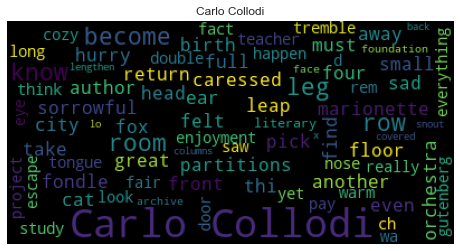

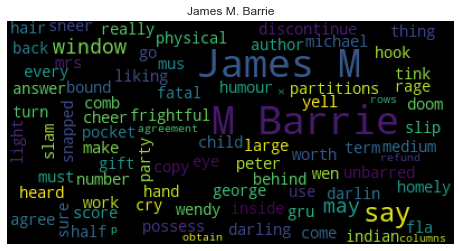

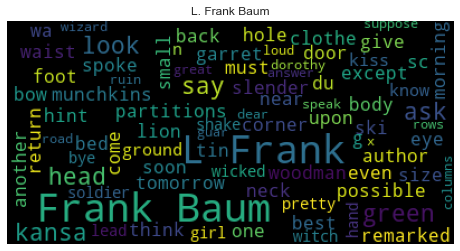

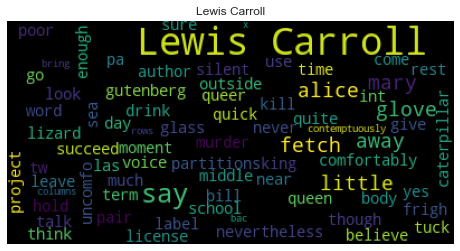

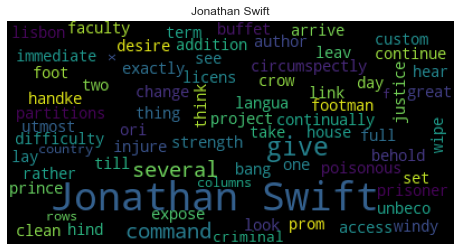

In [11]:
draw_chart(df,author_list)

In [12]:
df['char_count'] = df["partitions"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df.head()

,partitions,author,char_count
0,felt sad sorrowful pick floor fondle caressed ...,Carlo Collodi,513
1,find front row another leap orchestra head thi...,Carlo Collodi,533
2,away city fox cat return great hurry take four...,Carlo Collodi,506
3,full must know marionette even birth small ear...,Carlo Collodi,529
4,enjoyment teacher think study pay fair look wa...,Carlo Collodi,522


In [13]:
def draw_chart_histgram(all_books,author_list):    
    x, y = "char_count", "y"
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(x, fontsize=12)
    
    for i in all_books["author"].unique():
        sns.distplot(all_books[all_books["author"]==i][x], hist=True, kde=False, 
                     bins=10, hist_kws={"alpha":0.8}, 
                     axlabel="histogram", ax=ax[0])
        sns.distplot(all_books[all_books["author"]==i][x], hist=False, kde=True, 
                     kde_kws={"shade":True}, axlabel="density",   
                     ax=ax[1])
    ax[0].grid(True)
    ax[0].legend(all_books["author"].unique())
    ax[1].grid(True)
    plt.show()

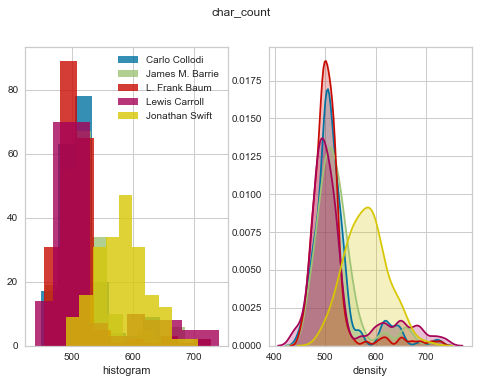

In [14]:
draw_chart_histgram(df,author_list)

In [15]:
def bow(df):
    vectorizer = CountVectorizer()
    bow_model = vectorizer.fit(df.partitions)
    X = bow_model.transform(df.partitions)
    df_bow = pd.DataFrame(X.toarray(),columns = bow_model.get_feature_names_out())
    print(df_bow)
    X_train, X_test, y_train, y_test = train_test_split(df_bow, Y, test_size = 0.20, random_state = 42)
    return X_train, X_test, y_train, y_test, df_bow

In [16]:
Y = df.author
Y

0       Carlo Collodi
1       Carlo Collodi
2       Carlo Collodi
3       Carlo Collodi
4       Carlo Collodi
            ...      
995    Jonathan Swift
996    Jonathan Swift
997    Jonathan Swift
998    Jonathan Swift
999    Jonathan Swift
Name: author, Length: 1000, dtype: object

In [ ]:
a = bow(df)
tsne = TSNEVisualizer()
tsne.fit(a[4],df["author"])
tsne.show()

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1,1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['partitions'], 20)
#for word, freq in common_words:
    #print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 words')

In [ ]:
def tf_idf(df):
    vectorizer = TfidfVectorizer()
    tf_idf_model = vectorizer.fit(df.partitions)
    tf_idf_out=tf_idf_model.transform(df.partitions)
    feature_names = tf_idf_model.get_feature_names_out()
    dense = tf_idf_out.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size = 0.20, random_state = 42)
    return X_train, X_test, y_train, y_test,df 

In [ ]:
t = tf_idf(df)
tsne = TSNEVisualizer()
tsne.fit(t[4],df["author"])
tsne.show()

In [ ]:
def n_gram(df , n):
    count_vect = CountVectorizer(ngram_range=(n , n))
    ngram_vectors=count_vect.fit_transform(df.partitions)
    df = pd.DataFrame(ngram_vectors.toarray(),columns=count_vect.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size = 0.20, random_state = 42)

    return X_train, X_test, y_train, y_test,df

In [ ]:
g = n_gram(df,2)
tsne = TSNEVisualizer()
tsne.fit(g[4],df["author"])
tsne.show()

In [ ]:
g3 = n_gram(df,3)
tsne = TSNEVisualizer()
tsne.fit(g3[4],df["author"])
tsne.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df.author = encoder.fit_transform(df.author)
Y = df.author
Y

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow,hh = bow(df)
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf,tt = tf_idf(df)
X_train_n_gram, X_test_n_gram, y_train_n_gram, y_test_n_gram,gg = n_gram(df,2)

In [ ]:
X_train_bow

In [ ]:
from sklearn.model_selection import cross_val_score
def cross_validation(model, X, y):
    scoring = ['accuracy', 'f1']
    scores = cross_val_score(model, X, y, cv=2)
    return scores

In [ ]:
def confusion_mx (y_test,y_pred,model_name):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True,fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


In [ ]:
def model_fit(X_train, y_train, X_test, y_test, nb, model_name):
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    results = cross_validation(nb, X_train, y_train)
  #  print(results)
#     test_score = results[0]
#     train_score = results[1]
#     X_axis = np.arange(len(test_score))
#     plt.bar(X_axis-0.2, test_score, 0.4, color='blue', label='Training')
#     plt.bar(X_axis+0.2, train_score, 0.4, color='red', label='Validation')
#     confusion_mx(y_test, y_pred, model_name)
#     plt.xlabel('Fold')
#     plt.ylabel('Accuracy')
#     plt.title('Training and Validation Scores')
#     plt.legend()
#     plt.show()
    train_scores = results.mean()
    X_axis = np.arange(len(results))
    plt.bar(X_axis-0.2, results, 0.4, color='black', label='Training')
    plt.bar(X_axis+0.2, train_scores, 0.4, color='red', label='Validation')
    plt.xticks(X_axis+3, results)
    plt.legend()
    plt.xlabel('Category')
    plt.ylabel('Scores')
    plt.title('Scores by Category')
    plt.show()
    confusion_mx(y_test, y_pred,model_name)
    
    
    #------------------------------------------------
# def model_fit(X_train, y_train, X_test, y_test,nb,model_name):
#     nb.fit(X_train, y_train)
#     y_pred = nb.predict(X_test)
#     results = cross_validation(nb,X_train,y_train)
#     confusion_mx(y_test, y_pred,model_name)

In [ ]:
def svm():
    svc = SVC(kernel="rbf")
    print(cross_validation(svc,X_train_bow,y_train_bow))
    print(cross_validation(svc,X_train_tf_idf,y_train_tf_idf))
   # print(cross_validation(svc,X_train_n_gram,y_train_n_gram))
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, svc,"SVM BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,svc,"SVM TF_IDF")
   # model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,svc,"SVM N_GRAM")
  

In [ ]:
svm()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes():
    nb = MultinomialNB()
    print(cross_validation(nb, X_train_bow, y_train_bow))
    print(cross_validation(nb,X_train_tf_idf,y_train_tf_idf))
    print(cross_validation(nb,X_train_n_gram,y_train_n_gram))
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,nb,"Naïve Bayes BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,nb,"Naïve Bayes TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,nb,"Naïve Bayes N_GRAM")

In [ ]:
naive_bayes()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def knn():
    k = 5  # Set the value of k for KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    print(cross_validation(knn, X_train_bow, y_train_bow))
    print(cross_validation(knn,X_train_tf_idf,y_train_tf_idf))
    print(cross_validation(knn,X_train_n_gram,y_train_n_gram))
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,knn,"KNN BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,knn,"KNN TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,knn,"KNN N_GRAM")

In [ ]:
knn()

In [ ]:
def RandomForest():
    Forest_model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 42)
    print(cross_validation(Forest_model,X_train_bow,y_train_bow))
    print(cross_validation(Forest_model,X_train_tf_idf,y_train_tf_idf))
    print(cross_validation(Forest_model,X_train_n_gram,y_train_n_gram))
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,Forest_model,"Random Forest BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,Forest_model,"Random Forest TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,Forest_model,"Random Forest N_GRAM")

In [ ]:
RandomForest()

In [ ]:
def SGD():
    sgd = SGDClassifier(random_state=42)
    print(cross_validation(sgd,X_train_bow,y_train_bow))
    print(cross_validation(sgd,X_train_tf_idf,y_train_tf_idf))
    print(cross_validation(sgd,X_train_n_gram,y_train_n_gram))
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,sgd,"SGD BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,sgd,"SGD TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,sgd,"SGD N_GRAM")

In [ ]:
SGD()

In [ ]:
def xgb_m():
    xgb_model = xgb.XGBClassifier(random_state=42)
    print(cross_validation(xgb_model,X_train_bow,y_train_bow))
    print(cross_validation(xgb_model,X_train_tf_idf,y_train_tf_idf))
    print(cross_validation(xgb_model,X_train_n_gram,y_train_n_gram))
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,xgb_model,"XGB BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,xgb_model,"XGB TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,xgb_model,"XGB N_GRAM")

In [ ]:
xgb_m() 